In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

## Load Data

In [17]:
data_dir = 'data'

In [18]:
os.listdir(f'{data_dir}')

['pop',
 '.DS_Store',
 'metal',
 'disco',
 'blues',
 'reggae',
 'classical',
 'rock',
 'hiphop',
 '.ipynb_checkpoints',
 'country',
 'jazz']

In [19]:
print(list(os.listdir(os.path.join(f'{data_dir}', 'country'))))

['country00052.png', 'country00046.png', 'country00091.png', 'country00085.png', 'country00084.png', 'country00090.png', 'country00047.png', 'country00053.png', 'country00045.png', 'country00051.png', 'country00079.png', 'country00086.png', 'country00092.png', 'country00093.png', 'country00087.png', 'country00078.png', 'country00050.png', 'country00044.png', 'country00068.png', 'country00040.png', 'country00054.png', 'country00083.png', 'country00097.png', 'country00096.png', 'country00082.png', 'country00055.png', 'country00041.png', 'country00069.png', 'country00057.png', 'country00043.png', 'country00094.png', 'country00080.png', 'country00081.png', 'country00095.png', 'country00042.png', 'country00056.png', 'country00031.png', 'country00025.png', 'country00019.png', 'country00018.png', 'country00024.png', 'country00030.png', 'country00026.png', 'country00032.png', 'country00033.png', 'country00027.png', 'country00023.png', 'country00037.png', 'country00036.png', 'country00022.png',

In [29]:
# Automatically loads in images and treats each as a different class by labeling
data = tf.keras.utils.image_dataset_from_directory('data', shuffle = True)
print(data.take(0))

Found 999 files belonging to 10 classes.
<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [30]:
# Converts Tensorflow dataset into numpy arrays and allows you to iterate over
data_iterator = data.as_numpy_iterator()

In [27]:
for images, labels in data.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Image data type:", images.dtype)
    print("Label data type:", labels.dtype)
    print("Sample image pixel range:", tf.reduce_min(images[0]).numpy(), "-", tf.reduce_max(images[0]).numpy())
    print("Sample labels:", labels.numpy())

Images shape: (32, 256, 256, 3)
Labels shape: (32,)
Image data type: <dtype: 'float32'>
Label data type: <dtype: 'int32'>
Sample image pixel range: 0.0 - 255.0
Sample labels: [3 2 8 4 4 5 7 1 4 9 3 7 9 3 0 9 7 4 2 0 3 3 0 1 2 3 5 1 9 9 8 0]


In [28]:
# Fetching batch of images 
while True:
    try:
        batch = data_iterator.next()
        images, labels = batch
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        print("Image data type:", images.dtype)
        print("Label data type:", labels.dtype)
        print("Sample image pixel range:", tf.reduce_min(images[0]).numpy(), "-", tf.reduce_max(images[0]).numpy())
        print("Sample labels:", labels)
    except StopIteration:
        print('reached end of dataset')
        break

reached end of dataset


In [31]:
batch = data_iterator.next()
images, labels = batch

# 32 images, height, width, channels
print(images.shape)

#32 labels for each image
print(labels.shape)

(32, 256, 256, 3)
(32,)


In [32]:
batch[1]

array([7, 5, 7, 3, 3, 4, 6, 2, 5, 9, 6, 5, 6, 1, 9, 9, 1, 0, 2, 2, 1, 3,
       7, 8, 7, 6, 7, 2, 1, 6, 4, 2], dtype=int32)

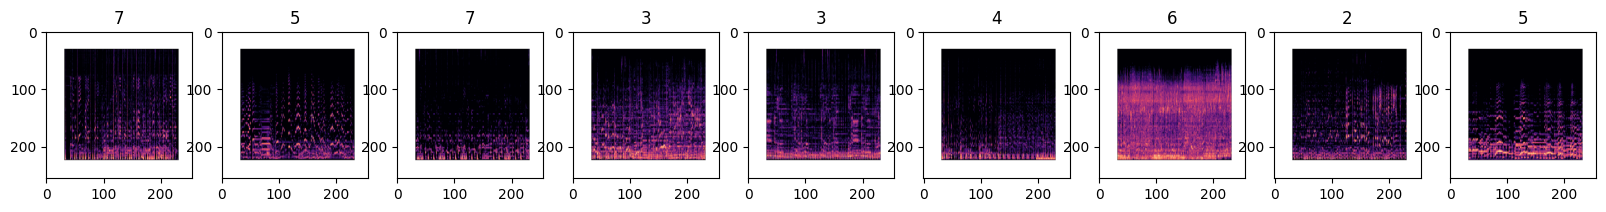

In [33]:
fig, ax = plt.subplots(ncols=9, figsize=(20,20))
for idx, img in enumerate(batch[0][:9]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Data Preprocessing

### Scaled images to between 0 and 1

In [34]:
scaled_data = data.map(lambda x, y: (x/255, y))

### Split into training, validation, and test sets

In [35]:
train_size = int(len(data) *.7)
val_size = int(len(data) *.2)
test_size = int(len(data) *.1)+1

In [36]:
print(train_size + val_size+ test_size)
print(len(data))

32
32


In [69]:
train_data = scaled_data.take(train_size)
val_data = scaled_data.skip(train_size).take(val_size)
test_data = scaled_data.skip(train_size + val_size).take(test_size)

train_iterator = train_data.as_numpy_iterator()

In [68]:
print(type(scaled_data))
print(type(train_data))
# print(type(train_iterator.next()))
# print(type(train_iterator.next()[0].dtype))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<class 'tensorflow.python.data.ops.take_op._TakeDataset'>
<class 'tuple'>
<class 'numpy.dtypes.Float32DType'>


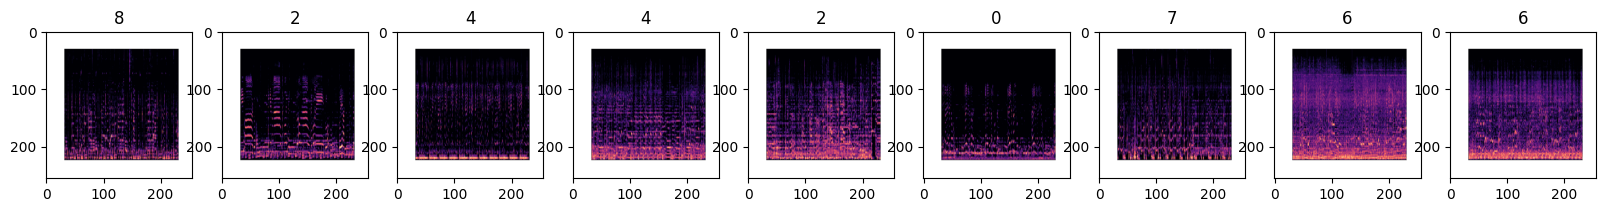

In [59]:
images, labels = train_iterator.next()
labels

fig, ax = plt.subplots(ncols=9, figsize=(20,20))
for idx, img in enumerate(images[:9]):
    ax[idx].imshow((img*255).astype('uint8'))
    ax[idx].title.set_text(labels[idx])

### Convert labels to one-hot encoded vectors

## Building CNN

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
model = Sequential()

# convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# max pooling layer
model.add(MaxPooling2D((2, 2)))

# second convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# second pooling layer
model.add(MaxPooling2D((2, 2)))

# # third convolution layer
# model.add(Conv2D(128, (3, 3), activation='relu'))

# flattening
model.add(Flatten())

# dense layer
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))

# dropout for regularization (decreases overfitting)
model.add(Dropout(0.5))
          
# second dense layer that
model.add(Dense(10, activation='softmax'))

In [43]:
model.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │   117,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,060,874 (450.37 MB)

 Trainable params: 118,060,874 (450.37 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.0945 - loss: 8.0227 - val_accuracy: 0.3021 - val_loss: 2.1984
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.2096 - loss: 2.1796 - val_accuracy: 0.4479 - val_loss: 1.9153
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.2862 - loss: 1.9118 - val_accuracy: 0.4740 - val_loss: 1.7422
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.4113 - loss: 1.6690 - val_accuracy: 0.5156 - val_loss: 1.5183
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5228 - loss: 1.4063 - val_accuracy: 0.6771 - val_loss: 1.0926
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6222 - loss: 1.1416 - val_accuracy: 0.7396 - val_loss: 0.9801
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6892 - loss: 0.9415 - val_accuracy: 0.7188 - val_loss: 0.8817
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7250 - loss: 0.8058 - val_accuracy: 0.7135 - val_loss:

In [58]:
test_loss, test_accuracy = model.evaluate(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.8917 - loss: 0.2807


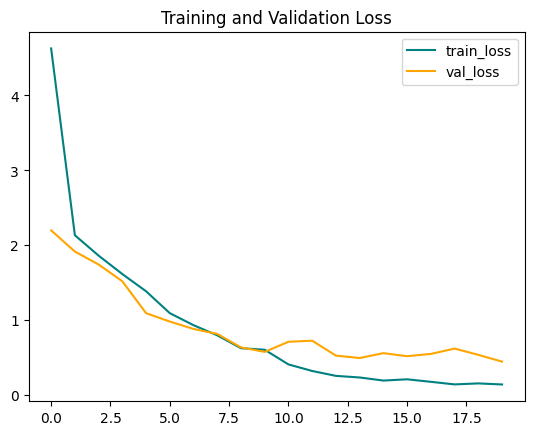

In [51]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], color = 'teal', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

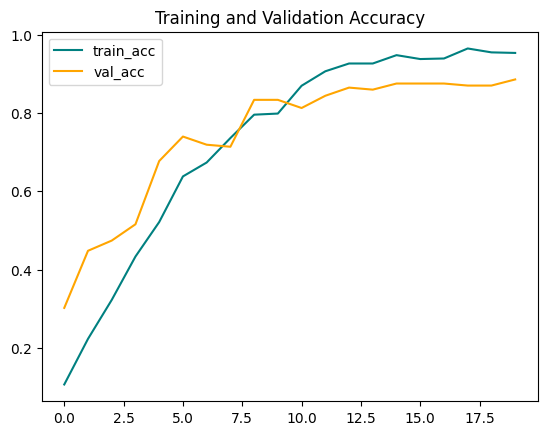

In [52]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color = 'teal', label = 'train_acc')
plt.plot(history.history['val_accuracy'], color = 'orange', label = 'val_acc')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## Evaluate Performance

In [63]:
y_hat = model.predict(test_data)
y_hat_classes = np.argmax(y_pred, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


In [65]:
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

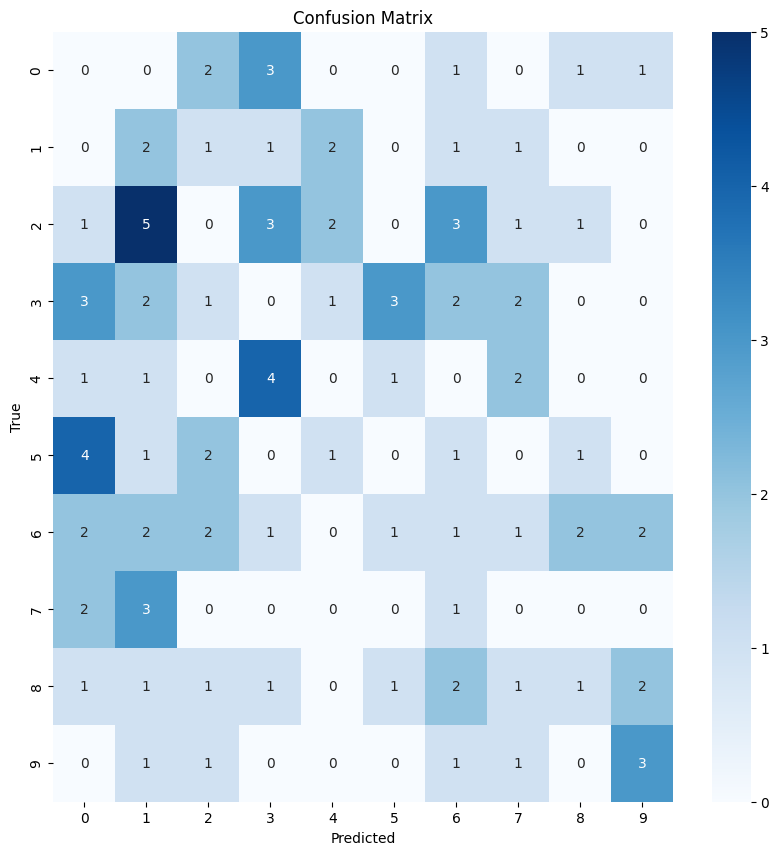

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()